# Прогнозирование температуры звезды

<div style="border:solid Chocolate 2px; padding: 40px">

## Описание проекта

Нам необходимо разработать нейронную сеть для обсерватории. Нейросеть должна помочь предсказывать абсолютную температуру на поверхности звезды. Обучить модель можно на данных базы обсерватории, где есть характеристики уже изученных 240 звёзд.

<b>Описание данны</b>

Характеристики звёзд содержат следующие данные:
* Относительная светимость L/Lo — светимость звезды относительно Солнца.
* Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
* Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
* Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
* Тип звезды.
* Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

В проекте мы:
* Загрузим и просмотрим данные.
* Проведём предобработку данных.
* Проведём исследователький анализ данных.
* Разработаем простую нейросеть и получим метрику RMSE на тестовых данных.
* Улучшим нейросеть припомощи разных методов.
* Сделаем выводы о работе моделей.


## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState

import math
from math import sqrt
from math import ceil

from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import random
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

C:\Users\Katya\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
path = 'C:/Users/Katya/Desktop/ds_learning/20sprint_модели и алгоритмы в машинном обучении/project/'

In [3]:
try:
    data = pd.read_csv(path + '6_class.csv', index_col = 0)
except FileNotFoundError:
    print('Данные не найдены')

In [4]:
def describe_data(data):
    display(data.head())
    display(data.info())
    print('Описание')
    display(data.describe)
    print('Гистограммы')
    data.hist(bins=50, figsize=(15, 20));

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


None

Описание


<bound method NDFrame.describe of      Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
0               3068          0.002400        0.1700                   16.12   
1               3042          0.000500        0.1542                   16.60   
2               2600          0.000300        0.1020                   18.70   
3               2800          0.000200        0.1600                   16.65   
4               1939          0.000138        0.1030                   20.06   
..               ...               ...           ...                     ...   
235            38940     374830.000000     1356.0000                   -9.93   
236            30839     834042.000000     1194.0000                  -10.63   
237             8829     537493.000000     1423.0000                  -10.73   
238             9235     404940.000000     1112.0000                  -11.23   
239            37882     294903.000000     1783.0000                   -7.80   

     

Гистограммы


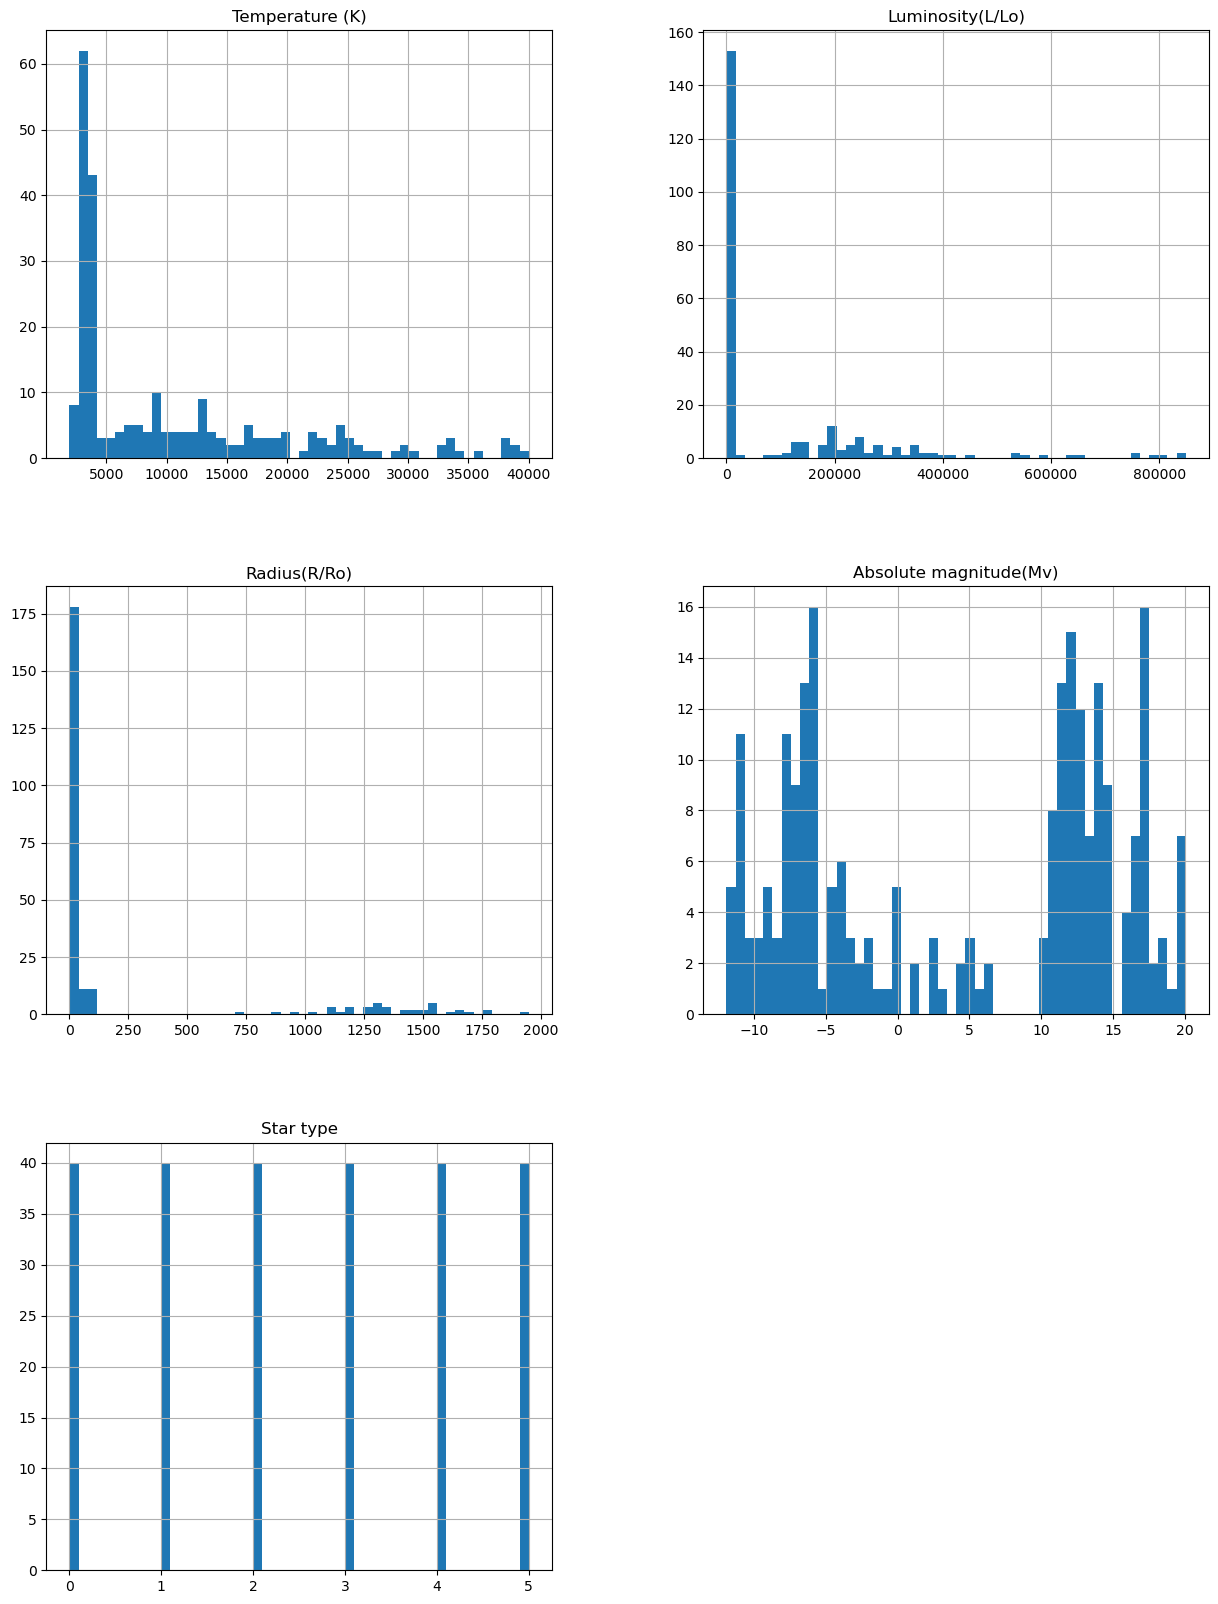

In [5]:
describe_data(data)

**Вывод**

Данные загружены. Пропусков в данных нет. Аномалий тоже нет. Посмотрим данные внимательнее.

## Предобработка и анализ данных

Для удобства работы изменим названия колонок.

In [6]:
data.columns = data.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('/', '_')

In [7]:
data.columns

Index(['Temperature_K', 'LuminosityL_Lo', 'RadiusR_Ro', 'Absolute_magnitudeMv',
       'Star_type', 'Star_color'],
      dtype='object')

### Работа с дубликатами

In [8]:
data.duplicated().sum()

0

Явных дубликатов в данных нет. Посмотрим категориальные признак "Star_color".

In [9]:
pd.Series(data['Star_color'].unique()).sort_values()

6                   Blue
13                 Blue 
1             Blue White
4             Blue white
17           Blue white 
18            Blue-White
7             Blue-white
10                Orange
16            Orange-Red
5     Pale yellow orange
0                    Red
2                  White
11          White-Yellow
8                Whitish
15             Yellowish
3        Yellowish White
12                 white
9           yellow-white
14             yellowish
dtype: object

В значениях "Star_color" есть дубликаты. Приведём значения к нижнему регистру и удалим лишние пробелы.

In [10]:
data['Star_color'] = data['Star_color'].str.lower().str.strip().str.replace('-', '_').str.replace(' ', '_')

In [11]:
pd.Series(data['Star_color'].unique()).sort_values()

5                   blue
1             blue_white
8                 orange
11            orange_red
4     pale_yellow_orange
0                    red
2                  white
9           white_yellow
6                whitish
7           yellow_white
10             yellowish
3        yellowish_white
dtype: object

Осталось несколько неявных дубликатов. Заменим их.

In [12]:
pd.Series(data['Star_color'].value_counts()).sort_values(ascending=False)

Star_color
red                   112
blue                   56
blue_white             41
white                  10
yellow_white            8
yellowish_white         3
yellowish               3
whitish                 2
orange                  2
pale_yellow_orange      1
white_yellow            1
orange_red              1
Name: count, dtype: int64

In [13]:
data['Star_color'] = (data['Star_color']
                      .replace(['white_yellow', 'yellowish_white', 'whitish', 'pale_yellow_orange', 'orange_red'],
                               ['yellow_white', 'yellow_white', 'white', 'orange', 'orange'], regex=False))

In [14]:
display(pd.Series(data['Star_color'].value_counts()).sort_values(ascending=False))

Star_color
red             112
blue             56
blue_white       41
white            12
yellow_white     12
orange            4
yellowish         3
Name: count, dtype: int64

**Вывод**

Мы провели предобработку данных. Для удобства работы переименовали столбцы. Удалили дубликаты в признаке 'Star_color'.

## Анализ данных

Посмотрим диаграмму рассеяния для всех признаков.

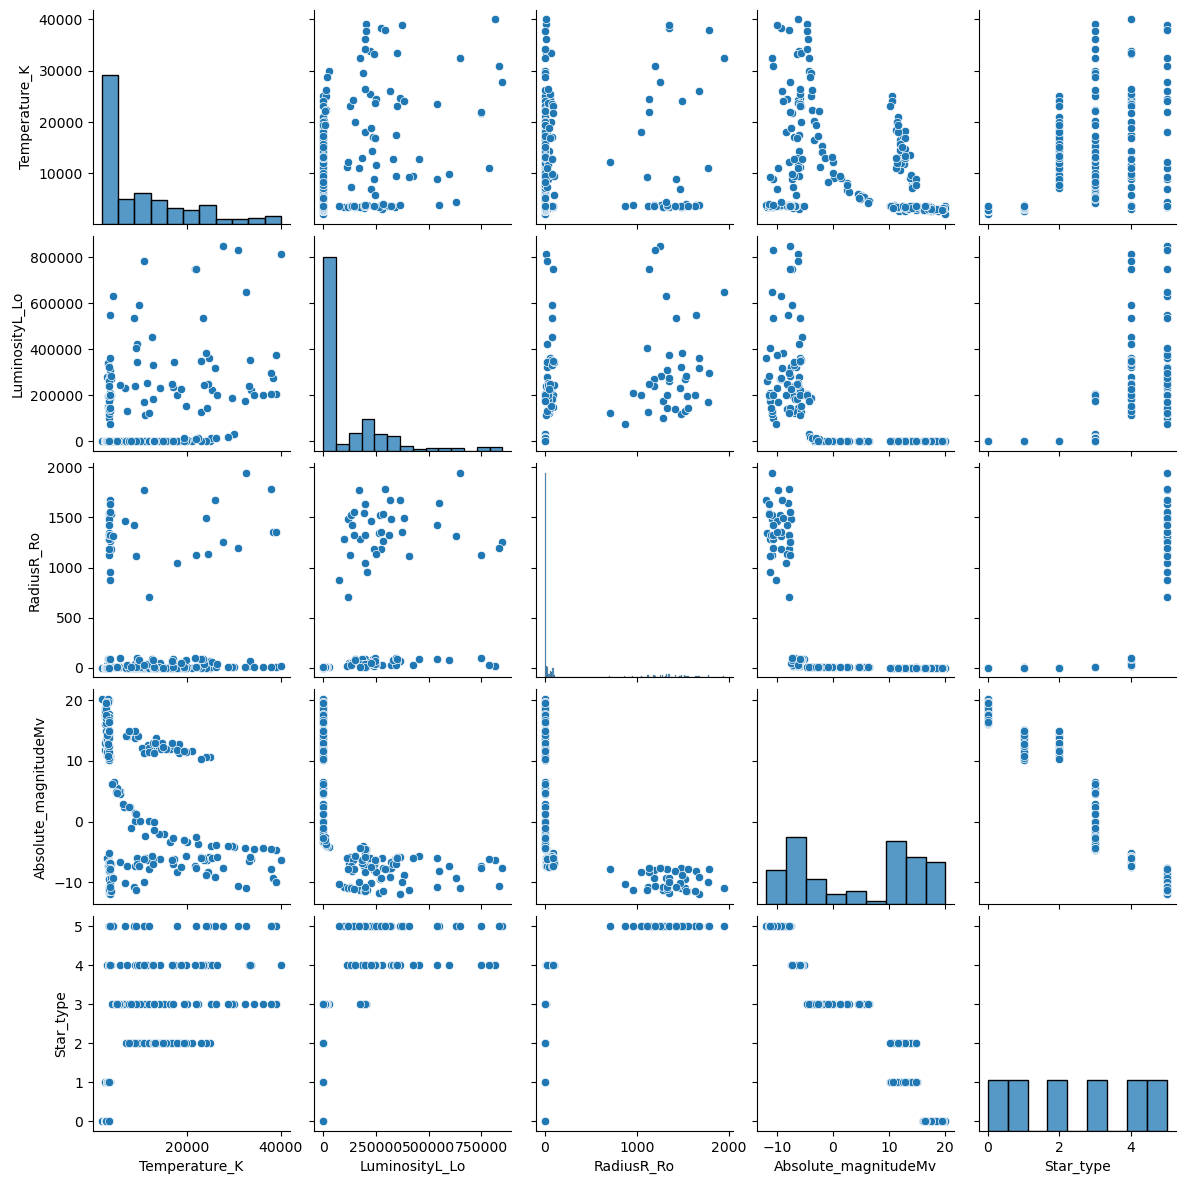

In [15]:
sns.pairplot(data)#[['Temperature__K', 'Luminosity_L_Lo', 'Radius_R_Ro', 'Absolute_magnitude_Mv']])
plt.gcf().set_size_inches(12,12);

In [16]:
def show_plot(data, col_list):
    for i in col_list:
        sns.displot(data, x=i, kde=True, color='purple', alpha=0.5,  height= 5 , aspect= 3, bins=200)
        plt.grid(True)
        plt.figsize=(12, 5)
        plt.title(f"Гистограмма {i}", fontsize=20)
        plt.xlabel(f'{i}', fontsize=14)
        plt.ylabel('Количество значений', fontsize=14)
        plt.xticks(rotation=0)
        plt.show();

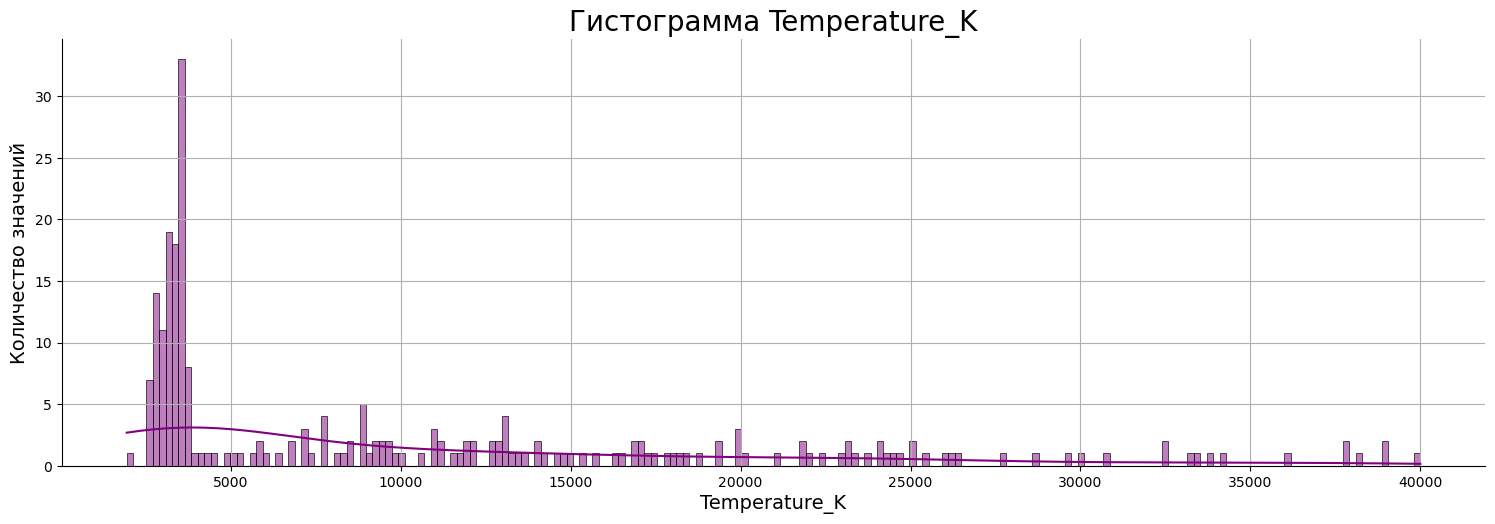

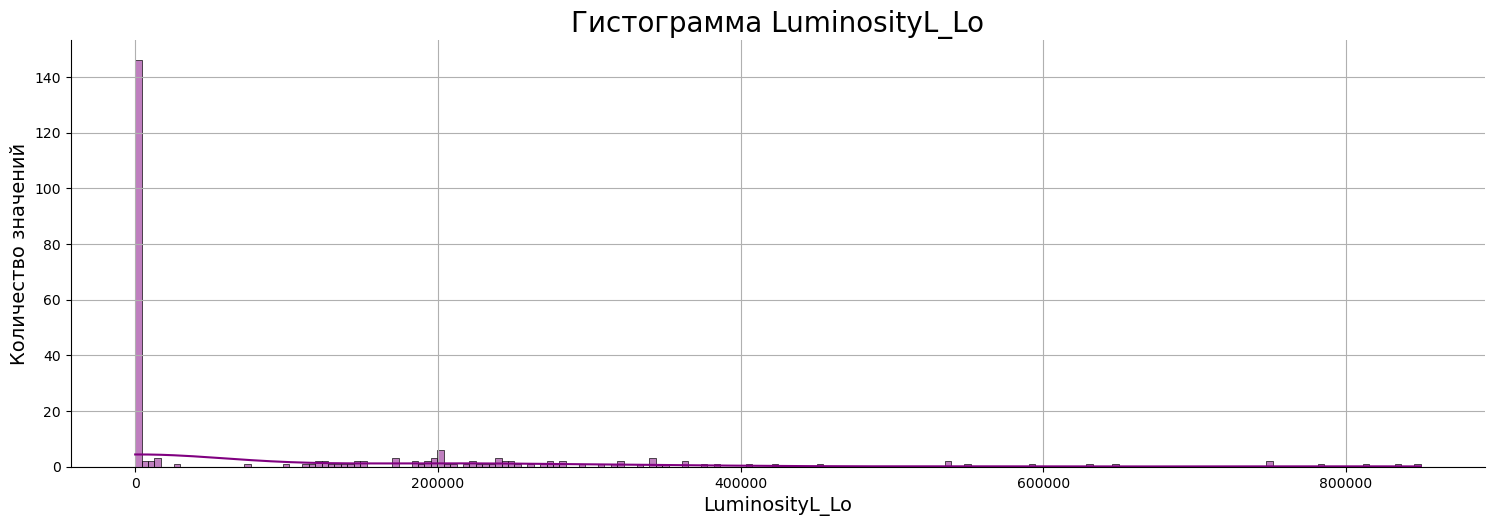

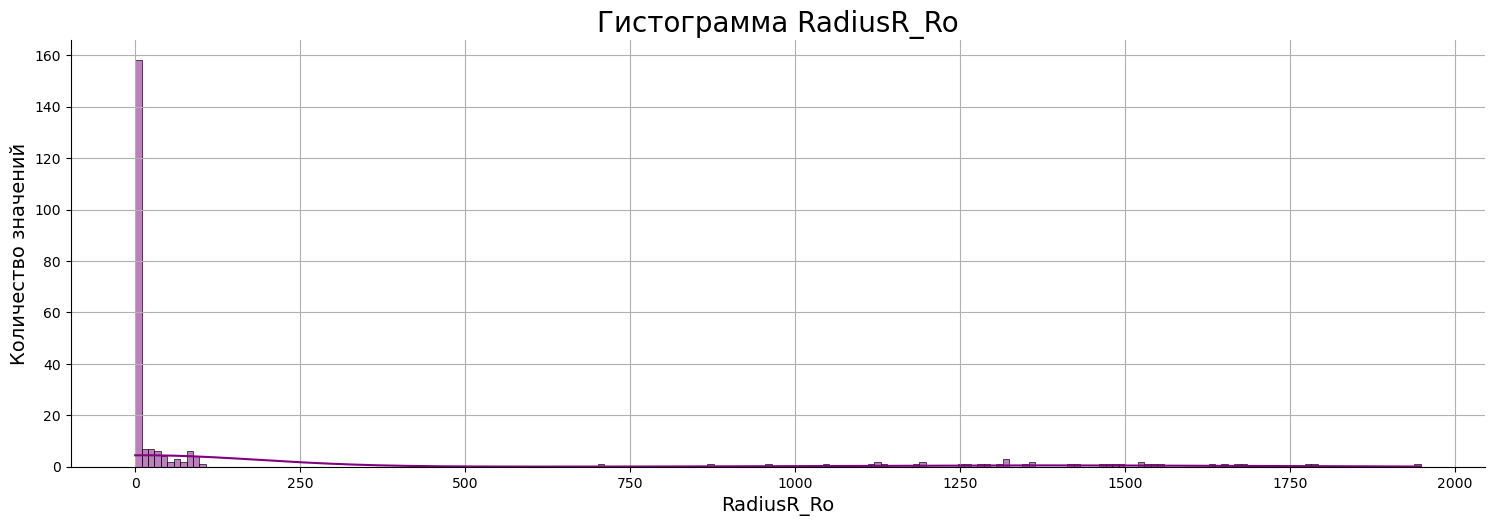

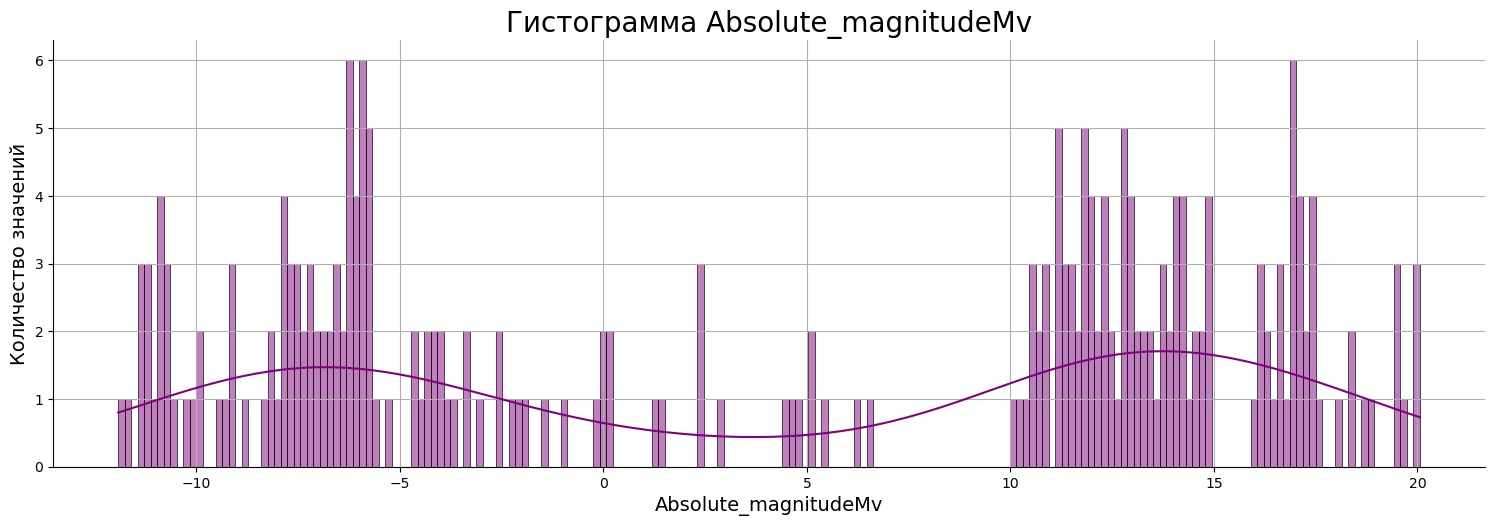

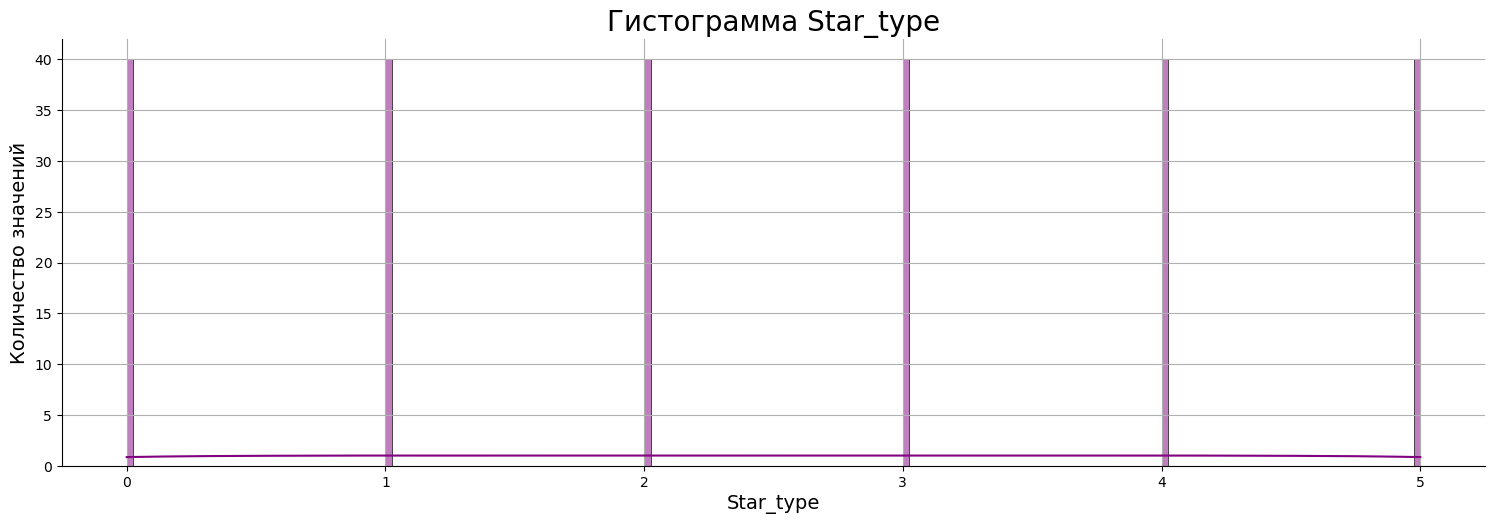

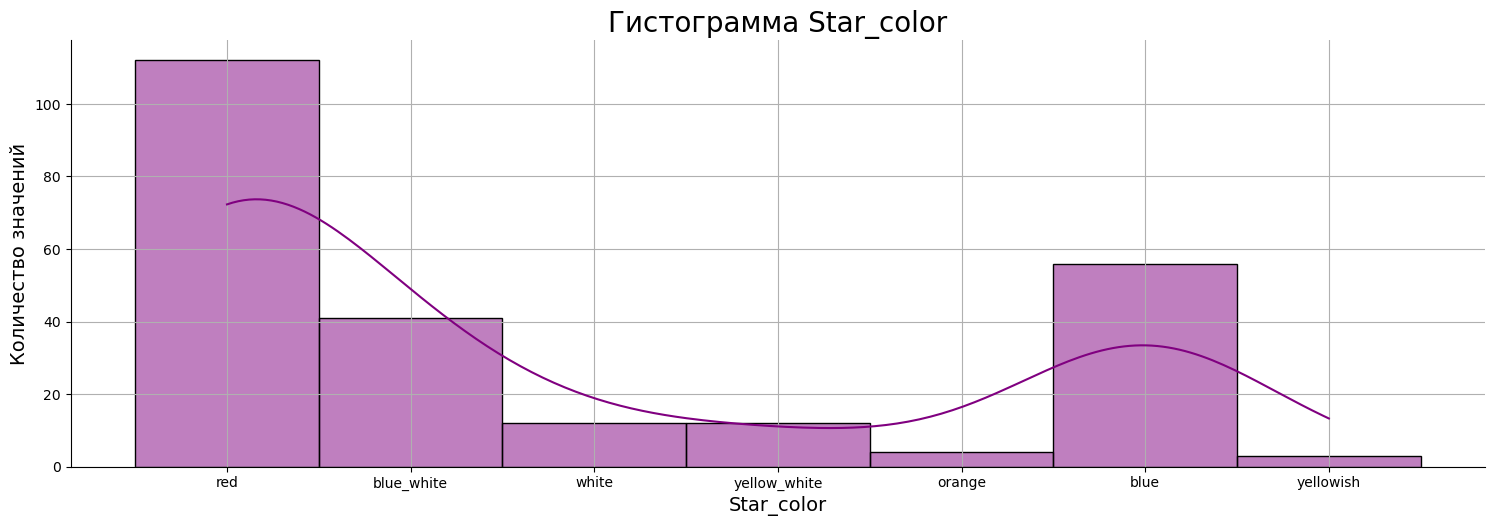

In [17]:
col_list = data.columns
show_plot(data, col_list)

По гистограммам можно увидеть, что в датасете присутсвует одинаковое количество всех типлв звёзд 'Star_type'.

Распределение температуры звёзд нормальное, скошенное влево. Это значит, что температура большей части звёзд мньше 5000. Остальные значения встречаются реже.

Почти у всех звёзд носительный радиус 'RadiusR_Ro' менее 200.

In [18]:
data.columns

Index(['Temperature_K', 'LuminosityL_Lo', 'RadiusR_Ro', 'Absolute_magnitudeMv',
       'Star_type', 'Star_color'],
      dtype='object')

In [19]:
numeric = ['Temperature_K', 'LuminosityL_Lo', 'RadiusR_Ro', 'Absolute_magnitudeMv']

In [20]:
corr = data[numeric].corr()
corr.style.background_gradient(cmap='coolwarm') #RdYlGn

,Temperature_K,LuminosityL_Lo,RadiusR_Ro,Absolute_magnitudeMv
Temperature_K,1.000000,0.393404,0.064216,-0.420261
LuminosityL_Lo,0.393404,1.000000,0.526516,-0.692619
RadiusR_Ro,0.064216,0.526516,1.000000,-0.608728
Absolute_magnitudeMv,-0.420261,-0.692619,-0.608728,1.000000


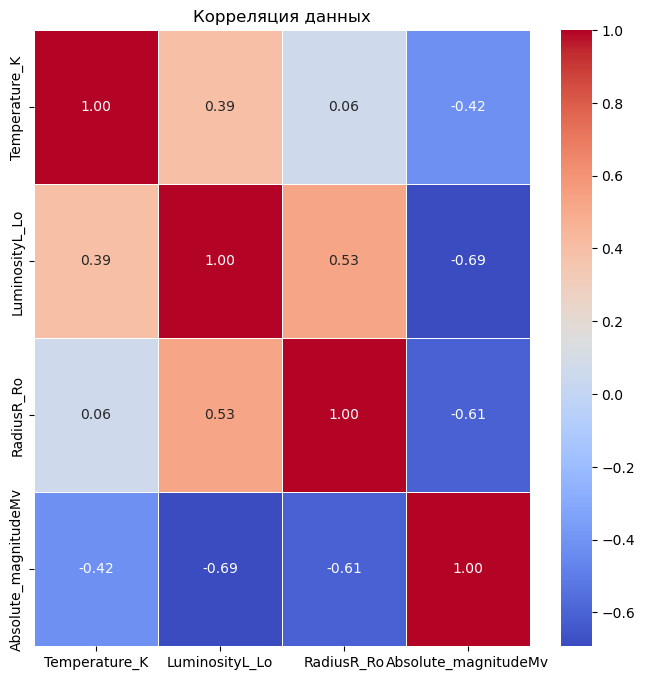

In [21]:
# Построение тепловой карты
plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Корреляция данных')
plt.show()

Значимой корреляции между признаками нет. Это значит, что для хорошей работы модели можно оставить их все. Стоит отдельно посмотреть на корреляции температуры звезды и её цвета. Сдалем это на графиках и после кодирования.

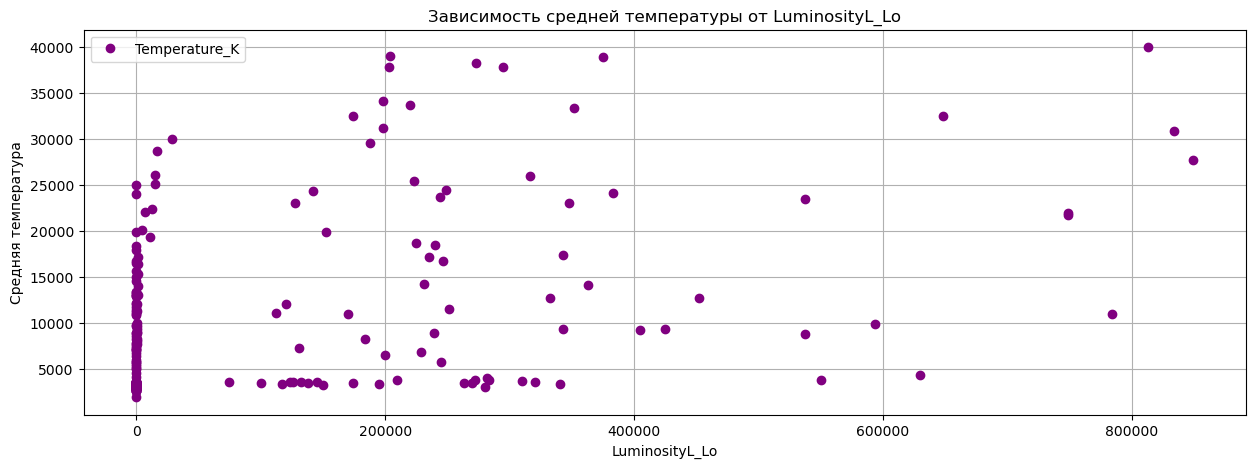

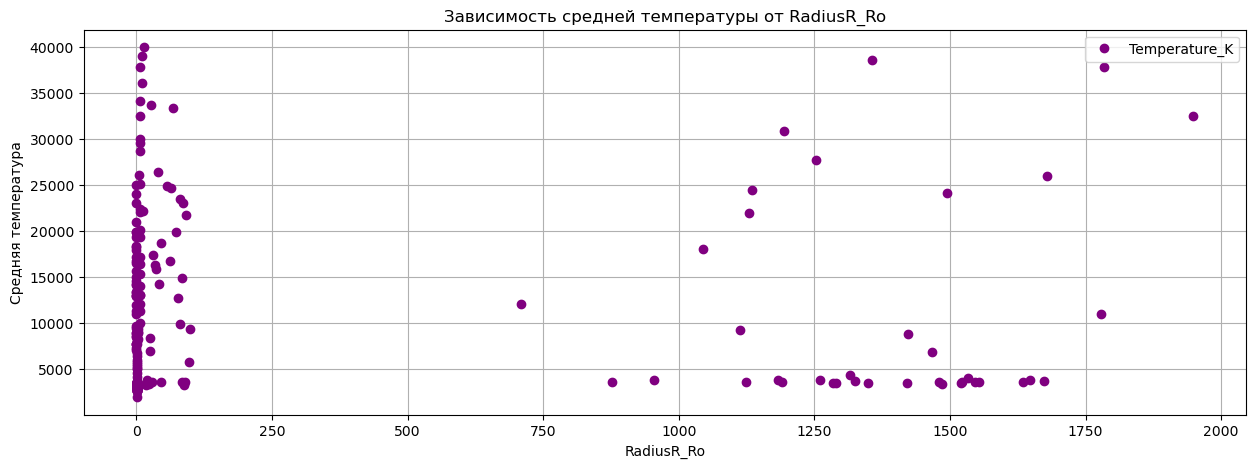

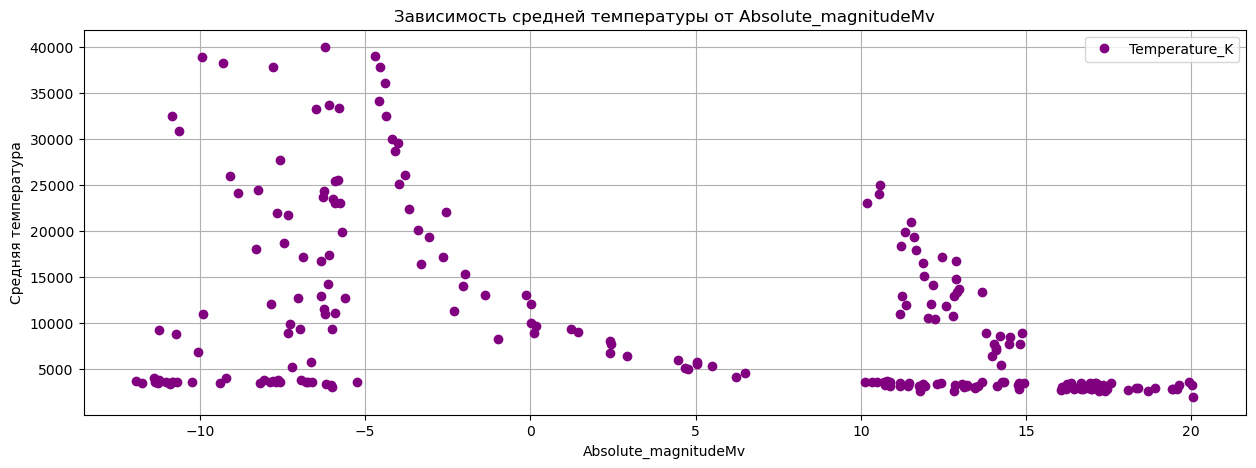

In [22]:
for i in data.columns.drop(['Temperature_K', 'Star_type', 'Star_color']):
    (
        data.pivot_table(index=i, values='Temperature_K', aggfunc='mean')
        .plot(color='purple', grid=(True), style='o', figsize=(15, 5))
    )
    plt.xlabel(f'{i}')
    plt.ylabel(f'Средняя температура')
    plt.title(f'Зависимость средней температуры от {i}')
    plt.show(); 

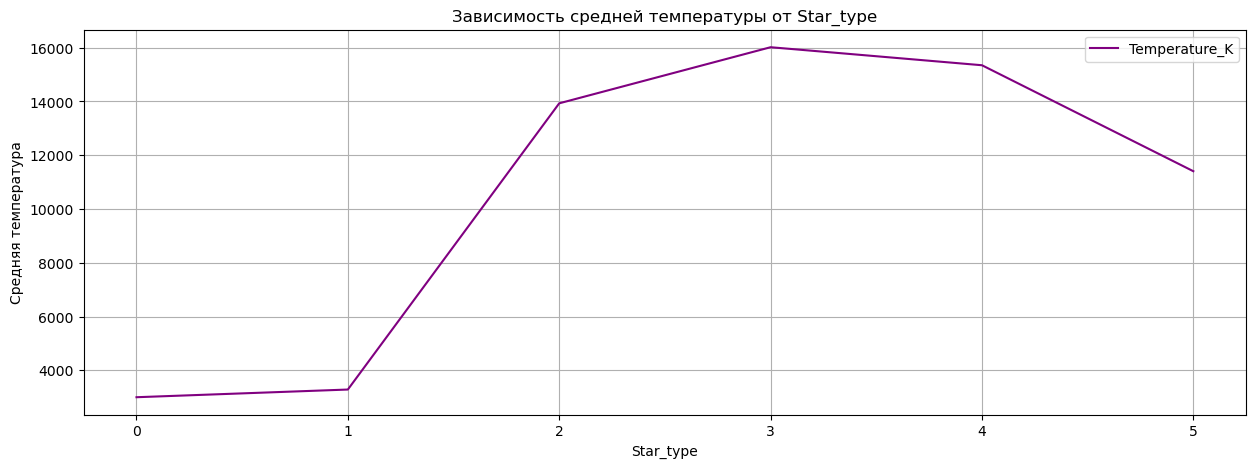

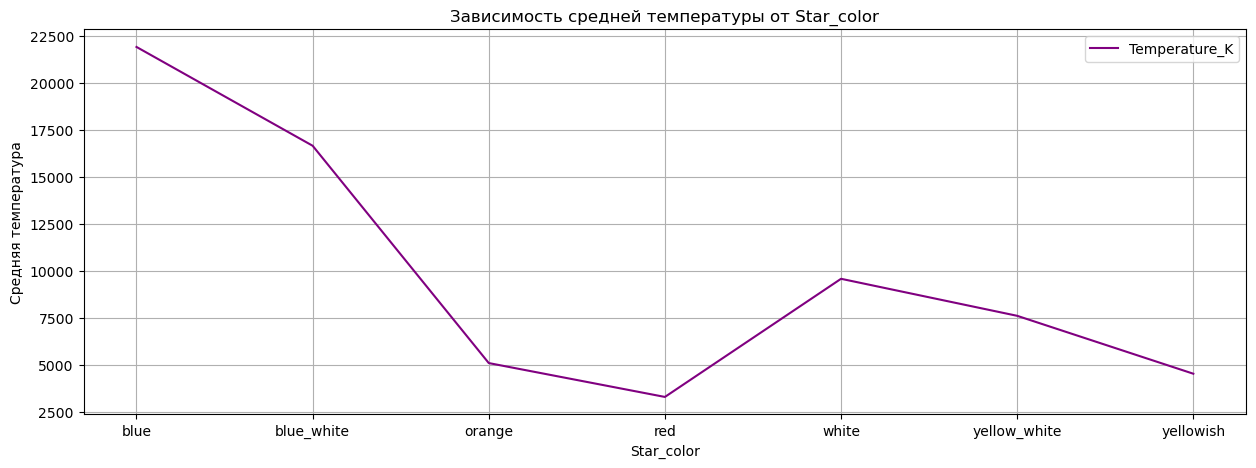

In [23]:
for i in ['Star_type', 'Star_color']:
    (
        data.pivot_table(index=i, values='Temperature_K', aggfunc='mean')
        .plot(color='purple', grid=(True), style='-', figsize=(15, 5))
    )
    plt.xlabel(f'{i}')
    plt.ylabel(f'Средняя температура')
    plt.title(f'Зависимость средней температуры от {i}')
    plt.show(); 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


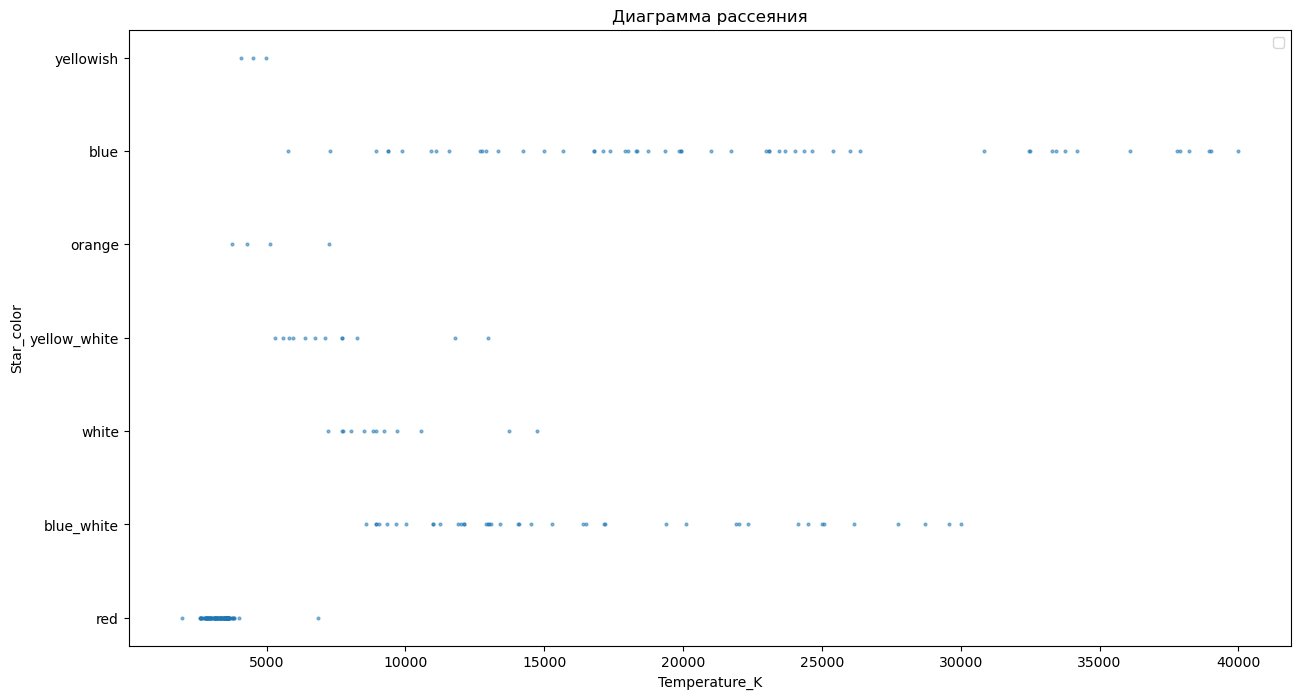

In [24]:
# check
data.plot(kind='scatter',
        y='Star_color' , x='Temperature_K', alpha=0.5, subplots=True, figsize=(15,8), s = 4)
plt.title('Диаграмма рассеяния');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


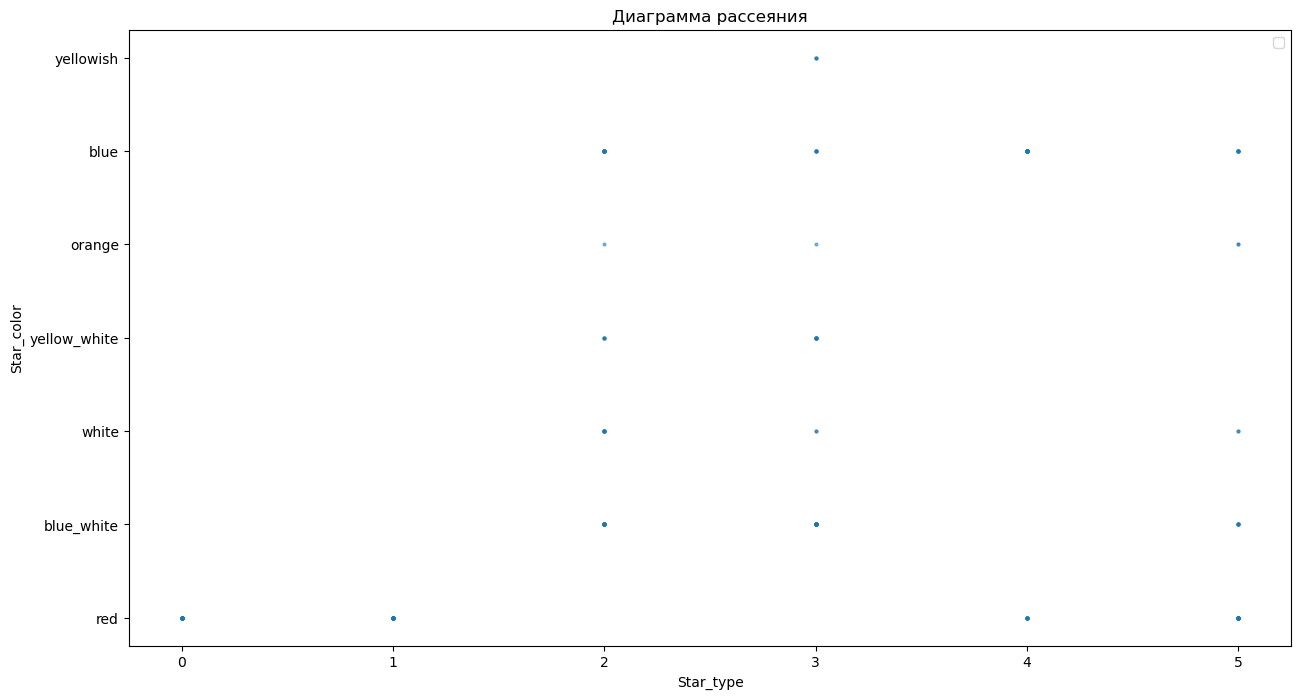

In [25]:
# check
data.plot(kind='scatter',
        y='Star_color' , x='Star_type', alpha=0.5, subplots=True, figsize=(15,8), s = 4)
plt.title('Диаграмма рассеяния');

По графику видно, что чем ниже цвет в спектре (чем ближе к красному), тем ниже её температура. Учтём это при кодирование категориального признака "Star_color".

Значения тепмературы голубых и бело-голубых звёзд действительно самые высокие. Но для них разброс значений очень большой. Вероятно модель будет менее точно определять температуру таких звёзд.

**Вывод**

По гистограммам можно увидеть, что в датасете присутсвует одинаковое количество всех типлв звёзд 'Star_type'.

Распределение температуры звёзд нормальное, скошенное влево. Это значит, что температура большей части звёзд мньше 5000. Остальные значения встречаются реже.

Почти у всех звёзд носительный радиус 'RadiusR_Ro' менее 200.

Значимой корреляции между признаками нет. Это значит, что для хорошей работы модели можно оставить их все. Стоит отдельно посмотреть на корреляции температуры звезды и её цвета. Сдалем это на графиках и после кодирования.


Видно, что чем ниже цвет в спектре (чем ближе к красному), тем ниже её температура. Учтём это при кодирование категориального признака "Star_color".

Значения тепмературы голубых и бело-голубых звёзд действительно самые высокие. Но для них разброс значений очень большой. Вероятно модель будет менее точно определять температуру таких звёзд.

Не смотря на то, что высокие значения 'Temperature_K', 'LuminosityL_Lo', 'RadiusR_Ro' встречаются редко, не стоит их удалять как выбросы, так как мы рискуем полностью избавиться от класса звёзд-гигантов.

## Подготовка данных для модели

### Разделение на обучающую и тестовую выборки

In [26]:
features_train, features_test, target_train, target_test = train_test_split(
    data.drop(columns=['Temperature_K']), 
    data['Temperature_K'], 
    test_size=0.3, 
    shuffle=True, stratify=data['Star_color'], random_state = RANDOM_STATE)

In [27]:
for i in ['features_train', 'features_test', 'target_train', 'target_test']:
    print("Количество строк в", i, ":", globals()[i].shape[0])

Количество строк в features_train : 168
Количество строк в features_test : 72
Количество строк в target_train : 168
Количество строк в target_test : 72


### Кодирование данных

In [28]:
categories = ['Star_color']

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(features_train[categories])
features_train_encoded = pd.DataFrame(
        data=encoder.transform(features_train[categories]).toarray(), 
        index=features_train.index,
        columns=encoder.get_feature_names_out()
    )
features_train_encoded.head()

,Star_color_blue,Star_color_blue_white,Star_color_orange,Star_color_red,Star_color_white,Star_color_yellow_white,Star_color_yellowish
80,0.0,0.0,0.0,0.0,0.0,1.0,0.0
162,1.0,0.0,0.0,0.0,0.0,0.0,0.0
228,1.0,0.0,0.0,0.0,0.0,0.0,0.0
178,0.0,1.0,0.0,0.0,0.0,0.0,0.0
184,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [29]:
features_train = features_train.drop(categories, axis=1).join(features_train_encoded)
features_train.head()

,LuminosityL_Lo,RadiusR_Ro,Absolute_magnitudeMv,Star_type,Star_color_blue,Star_color_blue_white,Star_color_orange,Star_color_red,Star_color_white,Star_color_yellow_white,Star_color_yellowish
80,0.000290,0.0120,14.090,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0
162,452000.000000,83.0000,-5.620,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0
228,347820.000000,86.0000,-5.905,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0
178,120000.000000,708.9000,-7.840,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0
184,0.000621,0.0773,17.080,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [30]:
features_train.shape

(168, 11)

In [31]:
features_test_encoded = pd.DataFrame(
        data=encoder.transform(features_test[categories]).toarray(), 
        index=features_test.index,
        columns=encoder.get_feature_names_out()
    )
features_test_encoded.head()

,Star_color_blue,Star_color_blue_white,Star_color_orange,Star_color_red,Star_color_white,Star_color_yellow_white,Star_color_yellowish
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0
91,0.0,0.0,0.0,0.0,0.0,0.0,1.0
123,0.0,0.0,0.0,1.0,0.0,0.0,0.0
129,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [32]:
features_test = features_test.drop(categories, axis=1).join(features_test_encoded)
features_test.head()

,LuminosityL_Lo,RadiusR_Ro,Absolute_magnitudeMv,Star_type,Star_color_blue,Star_color_blue_white,Star_color_orange,Star_color_red,Star_color_white,Star_color_yellow_white,Star_color_yellowish
4,0.000138,0.1030,20.060,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
91,0.153000,0.8650,6.506,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0
123,0.000150,0.0932,16.920,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
129,0.000437,0.0856,18.090,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68,0.000360,0.1180,17.390,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [33]:
features_test.shape

(72, 11)

### Масштабирование признаков

In [34]:
def scaler_func(x, numeric):
    x[numeric].plot(kind='density', figsize=(15, 5), grid=True)
    plt.xlabel('Признаки')
    plt.ylabel('Плотность признака');
    
    x[numeric] = scaler.transform(x[numeric])
    
    x[numeric].plot(kind='density', figsize=(15, 5), grid=True)
    plt.xlabel('Признаки')
    plt.ylabel('Плотность признака');

In [35]:
features_train.columns

Index(['LuminosityL_Lo', 'RadiusR_Ro', 'Absolute_magnitudeMv', 'Star_type',
       'Star_color_blue', 'Star_color_blue_white', 'Star_color_orange',
       'Star_color_red', 'Star_color_white', 'Star_color_yellow_white',
       'Star_color_yellowish'],
      dtype='object')

In [36]:
numeric = ['LuminosityL_Lo', 'RadiusR_Ro', 'Absolute_magnitudeMv']
numeric

['LuminosityL_Lo', 'RadiusR_Ro', 'Absolute_magnitudeMv']

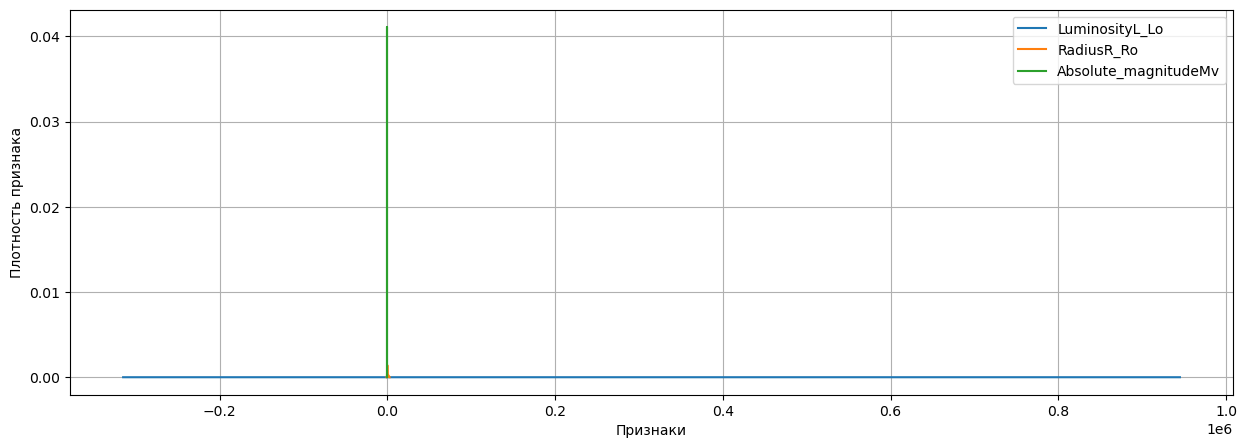

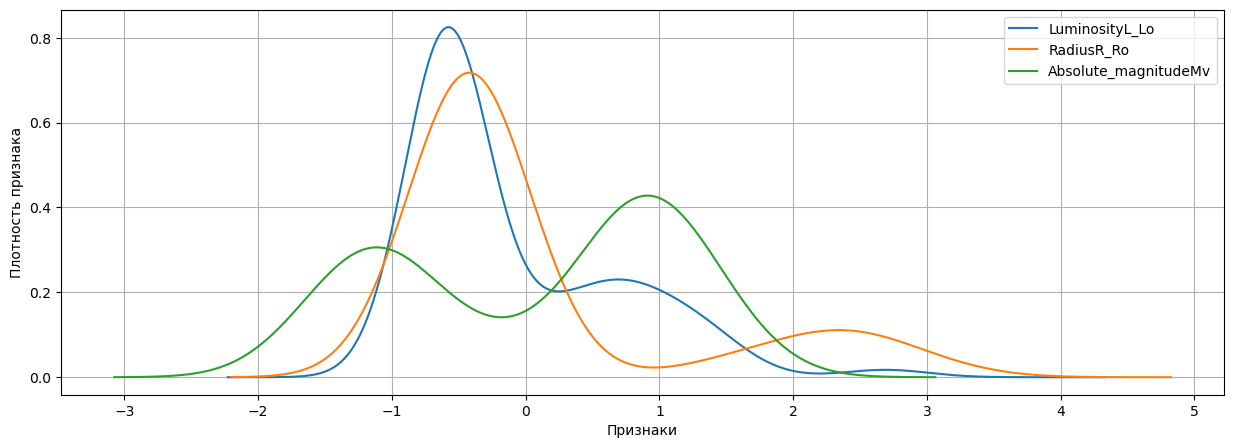

In [37]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
scaler_func(features_test, numeric)

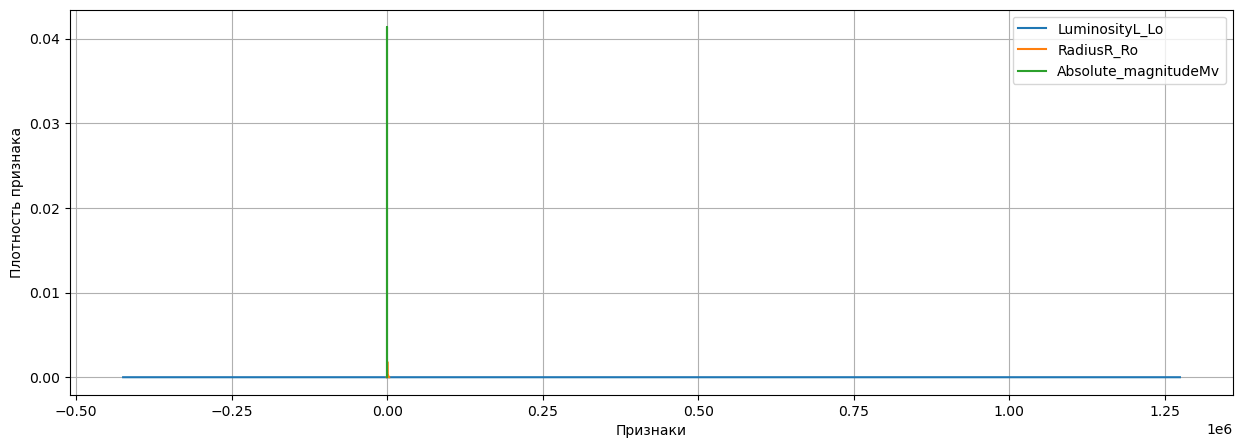

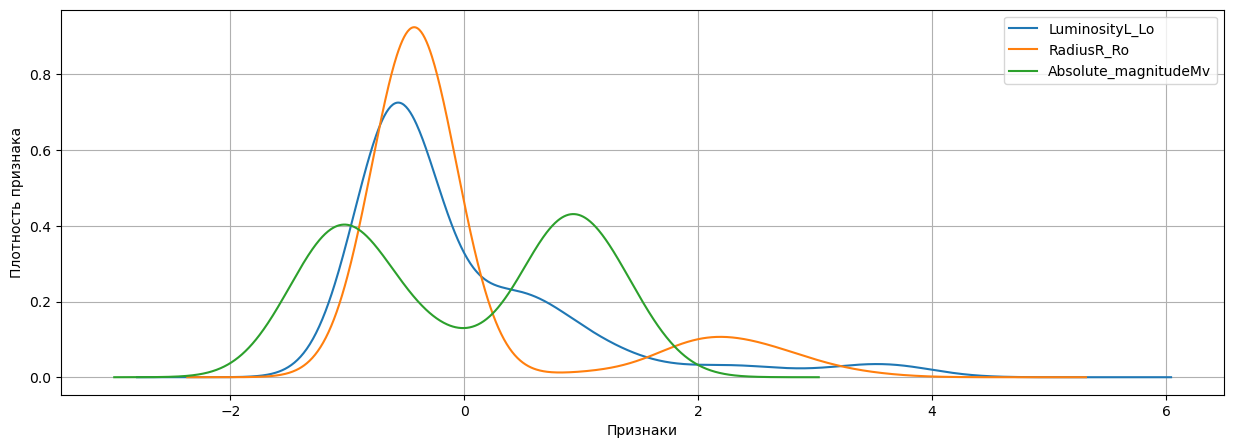

In [38]:
scaler_func(features_train, numeric)

Данные промасштабированы.

## Построение базовой нейронной сети

In [39]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)  

In [40]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()
        
        self.flatten = nn.Flatten(start_dim=0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
    
        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)
        
        return self.flatten(x)

In [41]:
# Функция обучения модели
def net_training(X_train, y_train):
    net.train()
# Обнуляем накопленный градиент
    optimizer.zero_grad()
# Получаем предсказания с текущими весами, прогнав признаки через сеть    
    preds = net.forward(X_train).flatten()
# Получаем значение функции потерь для предсказаний и истинных значений            
    loss_value = loss(preds, y_train)
# Вычисляем градиенты функции потерь
    loss_value.backward()
# Сделать шаг оптимизации            
    optimizer.step()

In [42]:
# Функция тестирования модели
def net_testing(epoch):
    net.eval()
    test_preds = net.forward(X_test).flatten()
    rmse_test = torch.sqrt(pow((y_test - test_preds), 2).sum() / y_test.size()[0])
    print(f'Эпоха {epoch}, RMSE на тестовых данных', rmse_test)
    return test_preds, rmse_test

In [43]:
def init_weights(layer):
    if type(layer) == nn.Linear: # Проверка, что слой – полносвязный

        nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(layer.bias)

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        nn.init.zeros_(layer.bias)

In [44]:
# Функция для построения графика "Факт-прогноз"

def show_preds(preds):
    preds = pd.DataFrame(test_preds.detach().numpy(), index=features_test.index.to_list())
    data_final = data.join(preds, how='right').rename(columns = {0:'preds'})
    data_final = data_final.sort_index(ascending=True)
    
#     #fig, axs = plt.subplots(2, figsize=(20, 15))
#     fig, ax = plt.subplots(figsize=(20, 5))
    
#     sns.barplot(data_final.index.to_list(), data_final['preds'], label = 'Прогноз', data = data_final,
#             ax=ax, color = 'r')
#     sns.barplot(data_final.index.to_list(),  data_final['Temperature_K'],
#             label = 'Факт', data = data_final,  ax=ax, color = 'b', alpha=0.5)


#     plt.title("Факт-прогноз", fontsize=20)
#     plt.xlabel("Номер звезды в талице данных", fontsize=16)
#     plt.ylabel("Температура звезды", fontsize=16)
#     plt.xticks(rotation=90)
#     ax.legend(ncol = 2, loc = 'upper left')
#     plt.show()
    fig, ax = plt.subplots(figsize=(20, 5))
        
    sns.barplot(data = data_final,
                x = data_final.index.to_list(), 
                y = data_final['preds'], 
                label = 'Прогноз', 
                ax=ax, color = 'r')

    sns.barplot(data = data_final,
                x = data_final.index.to_list(), 
                y = data_final['Temperature_K'],  
                label = 'Факт',  
                ax=ax, color = 'b', alpha=0.5)


    plt.title("Факт-прогноз", fontsize=20)
    plt.xlabel("Номер звезды в талице данных", fontsize=16)
    plt.ylabel("Температура звезды", fontsize=16)
    plt.xticks(rotation=90)
    ax.legend(ncol = 2, loc = 'upper left')
    plt.show()

Подберём оптимальное количество нейронов для скрытых слоёв.

In [45]:
# Подготовим тензоры для работы с pytorch
X_train = torch.FloatTensor(features_train.values)
X_test = torch.FloatTensor(features_test.values)
y_train = torch.FloatTensor(target_train.values)
y_test = torch.FloatTensor(target_test.values)

In [46]:
n_in_neurons = X_train.size()[1]
n_out_neurons = 1

df_report = pd.DataFrame(columns=['n_hidden_neurons_1', 'n_hidden_neurons_2', 'rmse_test'])
for n_hidden_neurons_1 in [3, 5,  8, 13, 15, 20, 25, 30, 40]:
    for n_hidden_neurons_2 in [3, 5,  8, 13, 15, 20, 25, 30, 40]:
        set_random_seed(42)

        net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

        net.apply(init_weights)

        optimizer = torch.optim.Adam(net.parameters(), lr=3e-1)
#         optimizer = torch.optim.Adam(net.parameters(), lr=1e-1)

        loss = nn.MSELoss()

        # определим количество эпох обучения
        num_epochs = 601
#         num_epochs = 10001

        for epoch in range(num_epochs):
            net_training(X_train, y_train)
            
        # для каждой n-ой эпохи считаем RMSE для тестовой выборки  
            if epoch % 100 == 0:
                test_preds, rmse_test = net_testing(epoch) 
                
        df_report.loc[len(df_report.index)] = [n_hidden_neurons_1, n_hidden_neurons_2, rmse_test.detach().numpy()]

Эпоха 0, RMSE на тестовых данных tensor(13228.8604, grad_fn=<SqrtBackward0>)
Эпоха 100, RMSE на тестовых данных tensor(6010.1143, grad_fn=<SqrtBackward0>)
Эпоха 200, RMSE на тестовых данных tensor(5405.3667, grad_fn=<SqrtBackward0>)
Эпоха 300, RMSE на тестовых данных tensor(5207.3345, grad_fn=<SqrtBackward0>)
Эпоха 400, RMSE на тестовых данных tensor(4743.9214, grad_fn=<SqrtBackward0>)
Эпоха 500, RMSE на тестовых данных tensor(4513.7026, grad_fn=<SqrtBackward0>)
Эпоха 600, RMSE на тестовых данных tensor(4380.8101, grad_fn=<SqrtBackward0>)
Эпоха 0, RMSE на тестовых данных tensor(13236.8057, grad_fn=<SqrtBackward0>)
Эпоха 100, RMSE на тестовых данных tensor(6432.0220, grad_fn=<SqrtBackward0>)
Эпоха 200, RMSE на тестовых данных tensor(5504.8833, grad_fn=<SqrtBackward0>)
Эпоха 300, RMSE на тестовых данных tensor(5317.2612, grad_fn=<SqrtBackward0>)
Эпоха 400, RMSE на тестовых данных tensor(5190.2471, grad_fn=<SqrtBackward0>)
Эпоха 500, RMSE на тестовых данных tensor(5174.5923, grad_fn=<Sqrt

Эпоха 200, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 300, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 400, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 500, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 600, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 0, RMSE на тестовых данных tensor(13232.5850, grad_fn=<SqrtBackward0>)
Эпоха 100, RMSE на тестовых данных tensor(5317.1719, grad_fn=<SqrtBackward0>)
Эпоха 200, RMSE на тестовых данных tensor(4961.9526, grad_fn=<SqrtBackward0>)
Эпоха 300, RMSE на тестовых данных tensor(4526.2798, grad_fn=<SqrtBackward0>)
Эпоха 400, RMSE на тестовых данных tensor(4456.8765, grad_fn=<SqrtBackward0>)
Эпоха 500, RMSE на тестовых данных tensor(4375.6543, grad_fn=<SqrtBackward0>)
Эпоха 600, RMSE на тестовых данных tensor(4391.7056, grad_fn=<SqrtBackward0>)
Эпоха 0, RMSE на тестовых данных tensor(13237.4873, grad_fn=

Эпоха 300, RMSE на тестовых данных tensor(4324.5903, grad_fn=<SqrtBackward0>)
Эпоха 400, RMSE на тестовых данных tensor(4214.8892, grad_fn=<SqrtBackward0>)
Эпоха 500, RMSE на тестовых данных tensor(4214.2319, grad_fn=<SqrtBackward0>)
Эпоха 600, RMSE на тестовых данных tensor(4183.9731, grad_fn=<SqrtBackward0>)
Эпоха 0, RMSE на тестовых данных tensor(13234.6182, grad_fn=<SqrtBackward0>)
Эпоха 100, RMSE на тестовых данных tensor(5279.1465, grad_fn=<SqrtBackward0>)
Эпоха 200, RMSE на тестовых данных tensor(4681.3291, grad_fn=<SqrtBackward0>)
Эпоха 300, RMSE на тестовых данных tensor(4404.3091, grad_fn=<SqrtBackward0>)
Эпоха 400, RMSE на тестовых данных tensor(4435.1167, grad_fn=<SqrtBackward0>)
Эпоха 500, RMSE на тестовых данных tensor(4475.6279, grad_fn=<SqrtBackward0>)
Эпоха 600, RMSE на тестовых данных tensor(4452.8291, grad_fn=<SqrtBackward0>)
Эпоха 0, RMSE на тестовых данных tensor(13212.7803, grad_fn=<SqrtBackward0>)
Эпоха 100, RMSE на тестовых данных tensor(5356.8789, grad_fn=<Sqrt

Эпоха 400, RMSE на тестовых данных tensor(4203.6172, grad_fn=<SqrtBackward0>)
Эпоха 500, RMSE на тестовых данных tensor(4144.2144, grad_fn=<SqrtBackward0>)
Эпоха 600, RMSE на тестовых данных tensor(4149.5869, grad_fn=<SqrtBackward0>)
Эпоха 0, RMSE на тестовых данных tensor(13218.7607, grad_fn=<SqrtBackward0>)
Эпоха 100, RMSE на тестовых данных tensor(5311.5557, grad_fn=<SqrtBackward0>)
Эпоха 200, RMSE на тестовых данных tensor(4802.6201, grad_fn=<SqrtBackward0>)
Эпоха 300, RMSE на тестовых данных tensor(4582.0825, grad_fn=<SqrtBackward0>)
Эпоха 400, RMSE на тестовых данных tensor(4570.3506, grad_fn=<SqrtBackward0>)
Эпоха 500, RMSE на тестовых данных tensor(4516.6348, grad_fn=<SqrtBackward0>)
Эпоха 600, RMSE на тестовых данных tensor(4381.5562, grad_fn=<SqrtBackward0>)
Эпоха 0, RMSE на тестовых данных tensor(13229.1143, grad_fn=<SqrtBackward0>)
Эпоха 100, RMSE на тестовых данных tensor(5368.2773, grad_fn=<SqrtBackward0>)
Эпоха 200, RMSE на тестовых данных tensor(4902.2261, grad_fn=<Sqrt

Эпоха 600, RMSE на тестовых данных tensor(4282.7271, grad_fn=<SqrtBackward0>)
Эпоха 0, RMSE на тестовых данных tensor(13183.9150, grad_fn=<SqrtBackward0>)
Эпоха 100, RMSE на тестовых данных tensor(5194.8228, grad_fn=<SqrtBackward0>)
Эпоха 200, RMSE на тестовых данных tensor(5137.2427, grad_fn=<SqrtBackward0>)
Эпоха 300, RMSE на тестовых данных tensor(5091.1421, grad_fn=<SqrtBackward0>)
Эпоха 400, RMSE на тестовых данных tensor(5003.8345, grad_fn=<SqrtBackward0>)
Эпоха 500, RMSE на тестовых данных tensor(4927.6787, grad_fn=<SqrtBackward0>)
Эпоха 600, RMSE на тестовых данных tensor(5089.9268, grad_fn=<SqrtBackward0>)
Эпоха 0, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 100, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 200, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 300, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 400, RMSE на тестовых данных tensor(13237.4873, grad_fn=<

Эпоха 300, RMSE на тестовых данных tensor(4655.5737, grad_fn=<SqrtBackward0>)
Эпоха 400, RMSE на тестовых данных tensor(4801.2197, grad_fn=<SqrtBackward0>)
Эпоха 500, RMSE на тестовых данных tensor(4893.7275, grad_fn=<SqrtBackward0>)
Эпоха 600, RMSE на тестовых данных tensor(4447.9463, grad_fn=<SqrtBackward0>)
Эпоха 0, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 100, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 200, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 300, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 400, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 500, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 600, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 0, RMSE на тестовых данных tensor(13237.4873, grad_fn=<SqrtBackward0>)
Эпоха 100, RMSE на тестовых данных tensor(13237.4873, grad_f

In [47]:
df_report.sort_values('rmse_test')

,n_hidden_neurons_1,n_hidden_neurons_2,rmse_test
7,3,30,3994.9463
25,8,30,4003.6685
67,30,15,4031.1174
21,8,13,4032.637
38,15,8,4059.9475
...,...,...,...
13,5,15,13237.487
18,8,3,13237.487
62,25,40,13237.487
55,25,5,13237.487


In [48]:
n_hidden_neurons_1_best = df_report[df_report['rmse_test'] == df_report['rmse_test']. min()].iloc[0][0]
n_hidden_neurons_2_best = df_report[df_report['rmse_test'] == df_report['rmse_test']. min()].iloc[0][1]
n_hidden_neurons_1_best, n_hidden_neurons_2_best

(3, 30)

In [49]:
n_in_neurons = X_train.size()[1]
n_hidden_neurons_1 = n_hidden_neurons_1_best
n_hidden_neurons_2 = n_hidden_neurons_2_best
n_out_neurons = 1

set_random_seed(42)

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr=3e-1)

loss = nn.MSELoss()

# определим количество эпох обучения
num_epochs = 601


for epoch in range(num_epochs):
    net_training(X_train, y_train)
    
# для каждой n-ой эпохи считаем RMSE для тестовой выборки  
    if epoch % 100 == 0:
        test_preds, rmse_test = net_testing(epoch)  

Эпоха 0, RMSE на тестовых данных tensor(13236.5723, grad_fn=<SqrtBackward0>)
Эпоха 100, RMSE на тестовых данных tensor(5443.9131, grad_fn=<SqrtBackward0>)
Эпоха 200, RMSE на тестовых данных tensor(4972.3223, grad_fn=<SqrtBackward0>)
Эпоха 300, RMSE на тестовых данных tensor(4691.1538, grad_fn=<SqrtBackward0>)
Эпоха 400, RMSE на тестовых данных tensor(4294.9546, grad_fn=<SqrtBackward0>)
Эпоха 500, RMSE на тестовых данных tensor(4103.8164, grad_fn=<SqrtBackward0>)
Эпоха 600, RMSE на тестовых данных tensor(3994.9463, grad_fn=<SqrtBackward0>)


In [50]:
# Создадим таблицу для записи результатов моделей
df_final_report = pd.DataFrame(columns=['model', 'rmse_test'])

In [51]:
df_final_report.loc[ len(df_final_report.index )] = ['простая нейросеть', rmse_test.detach().numpy()]
df_final_report

,model,rmse_test
0,простая нейросеть,3994.9463


In [52]:
test_preds.detach().numpy()

array([ 3302.5996,  4007.727 ,  3302.5996,  3302.5996,  3302.5996,
       21580.94  , 21257.375 ,  3302.5996,  6832.7065, 20995.162 ,
       29814.32  , 10116.131 , 13295.501 ,  6278.4165,  3302.5996,
       21418.3   , 20538.117 ,  3302.5996,  3302.5996,  3302.5996,
        3302.5996, 16854.523 , 18403.744 ,  3302.5996, 24645.83  ,
        3302.5996, 18675.75  ,  3302.5996,  3302.5996,  3302.5996,
       14527.53  ,  3302.5996,  3302.5996,  3302.5996, 36905.746 ,
       13819.9375, 14343.569 ,  6192.724 ,  3302.5996,  3302.5996,
        3302.5996, 10866.544 ,  9838.798 ,  3302.5996,  3302.5996,
        8724.103 , 19184.557 , 21057.799 , 20294.145 , 23780.479 ,
        6193.505 ,  4538.8516, 11012.741 , 10432.52  ,  5502.349 ,
       18393.098 , 15722.778 ,  4472.1567,  3302.5996,  3302.5996,
       21421.045 , 27827.596 ,  3302.5996,  3302.5996,  4442.9614,
        4133.912 , 20543.225 ,  7221.924 , 19821.268 ,  3302.5996,
        3302.5996, 20549.21  ], dtype=float32)

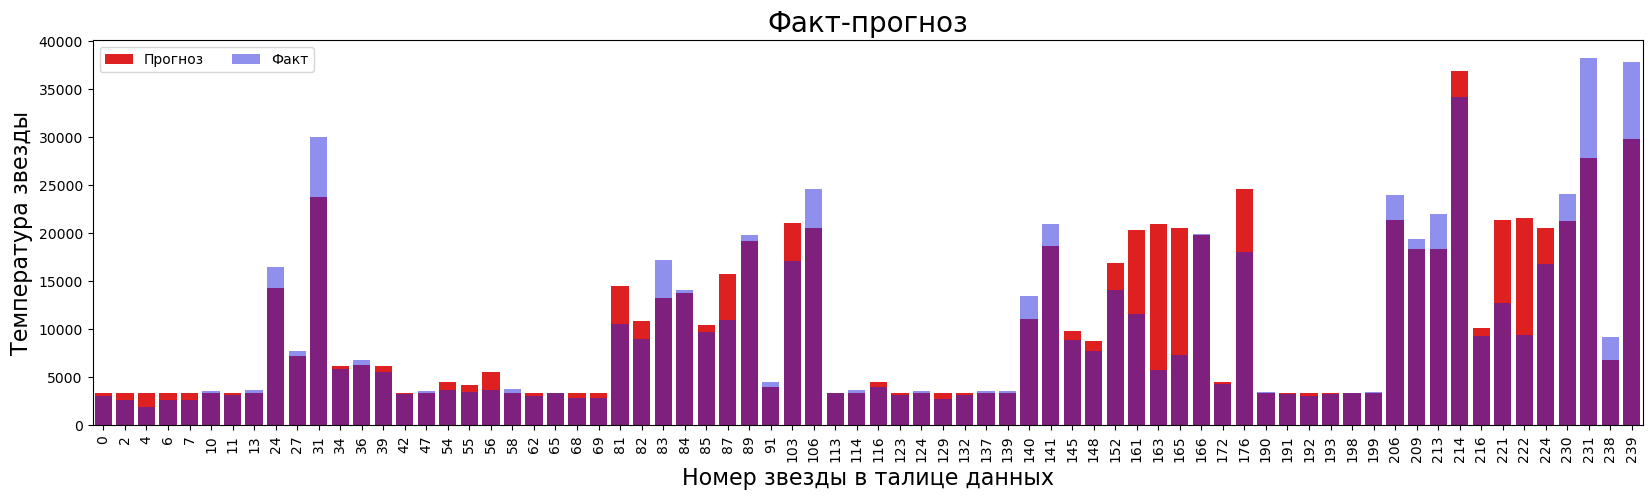

In [53]:
show_preds(test_preds)

## Улучшение нейронной сети

Попробуем улучшить нейронную сеть при помощи Batch Normalization или Dropout.

### Batch Normalization

In [54]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        
        
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        
        

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()
        
        self.flatten = nn.Flatten(start_dim=0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)
        
        return self.flatten(x)

In [55]:
n_in_neurons = X_train.size()[1]
n_hidden_neurons_1 = n_hidden_neurons_1_best
n_hidden_neurons_2 = n_hidden_neurons_2_best
n_out_neurons = 1


df_report = pd.DataFrame(columns=['batch_size', 'epoch', 'rmse_test'])
for batch_size in [10, 20, 50, 100]:
    
    set_random_seed(42)

    net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

    net.apply(init_weights)

    optimizer = torch.optim.Adam(net.parameters(), lr=3e-1)

    loss = nn.MSELoss()

    # определим количество эпох обучения
    num_epochs = 801
    test_epoch = 100

    batch_size = batch_size
    num_batches = ceil(len(X_train) / batch_size)

    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train))# создайте случайную перестановку индексов объектов
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size  # посчитайте номер стартового объекта батча
            
            net.train()
            optimizer.zero_grad()

            batch_indexes = order[start_idx:start_idx + batch_size] # извлеките индексы объектов текущего обатча
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            net_training(X_batch, y_batch)
        if epoch % test_epoch == 0:
            test_preds, rmse_test = net_testing(epoch)
            
            df_report.loc[len(df_report.index)] = [batch_size, epoch, rmse_test.detach().numpy()]

Эпоха 0, RMSE на тестовых данных tensor(12697.6602, grad_fn=<SqrtBackward0>)
Эпоха 100, RMSE на тестовых данных tensor(4921.9688, grad_fn=<SqrtBackward0>)
Эпоха 200, RMSE на тестовых данных tensor(4581.4653, grad_fn=<SqrtBackward0>)
Эпоха 300, RMSE на тестовых данных tensor(4642.6016, grad_fn=<SqrtBackward0>)
Эпоха 400, RMSE на тестовых данных tensor(4593.8970, grad_fn=<SqrtBackward0>)
Эпоха 500, RMSE на тестовых данных tensor(4714.4917, grad_fn=<SqrtBackward0>)
Эпоха 600, RMSE на тестовых данных tensor(4777.5742, grad_fn=<SqrtBackward0>)
Эпоха 700, RMSE на тестовых данных tensor(4976.1509, grad_fn=<SqrtBackward0>)
Эпоха 800, RMSE на тестовых данных tensor(4854.5015, grad_fn=<SqrtBackward0>)
Эпоха 0, RMSE на тестовых данных tensor(13161.0869, grad_fn=<SqrtBackward0>)
Эпоха 100, RMSE на тестовых данных tensor(4798.9458, grad_fn=<SqrtBackward0>)
Эпоха 200, RMSE на тестовых данных tensor(4619.1338, grad_fn=<SqrtBackward0>)
Эпоха 300, RMSE на тестовых данных tensor(4666.9443, grad_fn=<Sqrt

In [56]:
batch_size = df_report[df_report['rmse_test'] == df_report['rmse_test']. min()].iloc[0][0]
num_epochs = df_report[df_report['rmse_test'] == df_report['rmse_test']. min()].iloc[0][1]
batch_size, num_epochs

(50, 700)

In [57]:
n_in_neurons = X_train.size()[1]
n_hidden_neurons_1 = n_hidden_neurons_1_best
n_hidden_neurons_2 = n_hidden_neurons_2_best
n_out_neurons = 1


set_random_seed(42)

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr=3e-1)
#optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss = nn.MSELoss()
       
        
test_epoch = 100 # num_epochs #601    


for epoch in range(num_epochs):
    
    order = np.random.permutation(len(X_train)) # создайте случайную перестановку индексов объектов
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size # посчитайте номер стартового объекта батча
        
        net.train()
        optimizer.zero_grad()
  
        batch_indexes = order[start_index:start_index + batch_size] # извлеките индексы объектов текущего обатча
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        net_training(X_batch, y_batch)
    
    # для каждой n-ой эпохи считаем RMSE для тестовой выборки  
    if epoch % 100 == 0:
        test_preds = net_testing(epoch) 

Эпоха 0, RMSE на тестовых данных tensor(13230.1357, grad_fn=<SqrtBackward0>)
Эпоха 100, RMSE на тестовых данных tensor(4910.6401, grad_fn=<SqrtBackward0>)
Эпоха 200, RMSE на тестовых данных tensor(4673.7695, grad_fn=<SqrtBackward0>)
Эпоха 300, RMSE на тестовых данных tensor(4462.9214, grad_fn=<SqrtBackward0>)
Эпоха 400, RMSE на тестовых данных tensor(4724.0166, grad_fn=<SqrtBackward0>)
Эпоха 500, RMSE на тестовых данных tensor(4490.2944, grad_fn=<SqrtBackward0>)
Эпоха 600, RMSE на тестовых данных tensor(4533.7163, grad_fn=<SqrtBackward0>)


In [58]:
df_final_report.loc[ len(df_final_report.index )] = ['нейросеть c Batch Normalization', rmse_test.detach().numpy()]
df_final_report

,model,rmse_test
0,простая нейросеть,3994.9463
1,нейросеть c Batch Normalization,4423.7983


### Dropout

In [59]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        
        self.dp1 = nn.Dropout(p=0.4)
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        
        self.dp2 = nn.Dropout(p=0.4)

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()
        
        self.flatten = nn.Flatten(start_dim=0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dp1(x)
    
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dp2(x)

        x = self.fc3(x)
        x = self.act3(x)
        
        return self.flatten(x)

In [60]:
n_in_neurons = X_train.size()[1]
n_hidden_neurons_1 = n_hidden_neurons_1_best
n_hidden_neurons_2 = n_hidden_neurons_2_best
n_out_neurons = 1


set_random_seed(42)

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr=3e-1)

loss = nn.MSELoss()

# определим количество эпох обучения
num_epochs = 501


for epoch in range(num_epochs):
    net_training(X_train, y_train)
    
# для каждой n-ой эпохи считаем RMSE для тестовой выборки  
    if epoch % 100 == 0:
        test_preds, rmse_test = net_testing(epoch)  

Эпоха 0, RMSE на тестовых данных tensor(13233.1191, grad_fn=<SqrtBackward0>)
Эпоха 100, RMSE на тестовых данных tensor(5366.2759, grad_fn=<SqrtBackward0>)
Эпоха 200, RMSE на тестовых данных tensor(5294.3975, grad_fn=<SqrtBackward0>)
Эпоха 300, RMSE на тестовых данных tensor(5091.2686, grad_fn=<SqrtBackward0>)
Эпоха 400, RMSE на тестовых данных tensor(5261.4980, grad_fn=<SqrtBackward0>)
Эпоха 500, RMSE на тестовых данных tensor(4848.8652, grad_fn=<SqrtBackward0>)


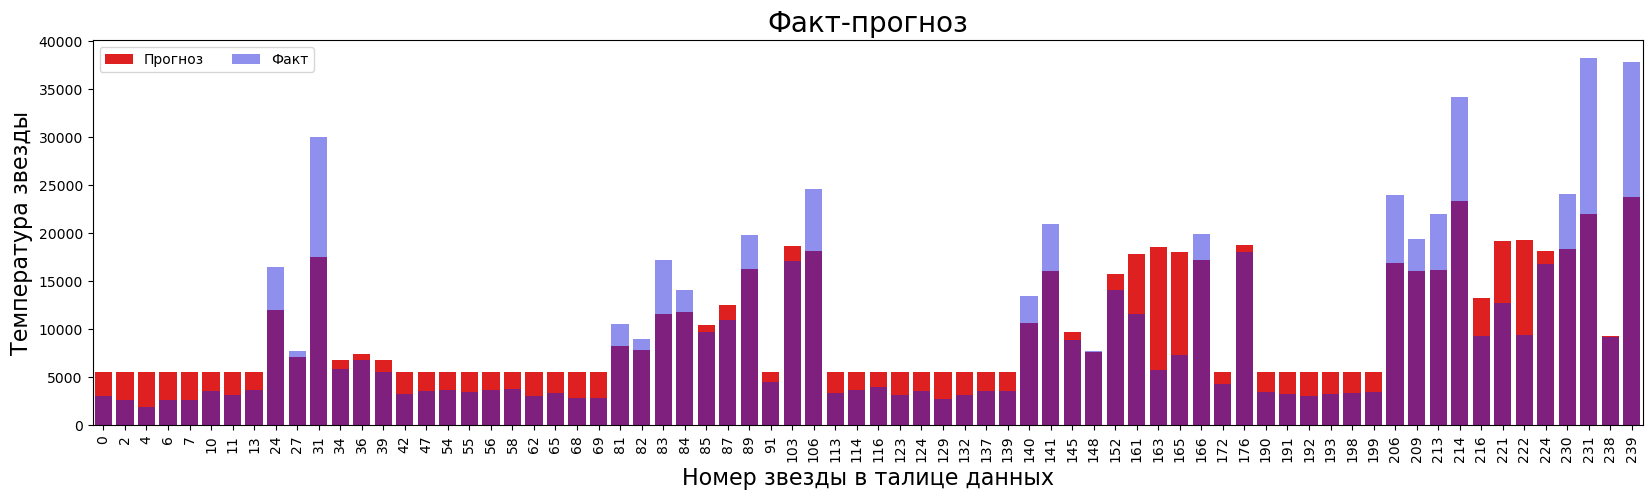

In [61]:
show_preds(test_preds)

In [62]:
df_final_report.loc[ len(df_final_report.index )] = ['нейросеть c Dropout', rmse_test.detach().numpy()]
df_final_report

,model,rmse_test
0,простая нейросеть,3994.9463
1,нейросеть c Batch Normalization,4423.7983
2,нейросеть c Dropout,4848.865


## Выводы

**Вывод**

* Данные загружены. Пропусков в данных нет. Аномалий тоже нет. Посмотрим данные внимательнее.


* Мы провели предобработку данных. Для удобства работы переименовали столбцы. Удалили дубликаты в признаке 'Star_color'.


* Мы провели иследовательский анализ данных.

По гистограммам можно увидеть, что в датасете присутсвует одинаковое количество всех типлв звёзд 'Star_type'.

Распределение температуры звёзд нормальное, скошенное влево. Это значит, что температура большей части звёзд мньше 5000. Остальные значения встречаются реже.

Почти у всех звёзд носительный радиус 'RadiusR_Ro' менее 200.

Значимой корреляции между признаками нет. Это значит, что для хорошей работы модели можно оставить их все. Стоит отдельно посмотреть на корреляции температуры звезды и её цвета. Сдалем это на графиках и после кодирования.


Видно, что чем ниже цвет в спектре (чем ближе к красному), тем ниже её температура. Мы учли это при кодирование категориального признака "Star_color" и выявили значимую корреляция (0.79) между цветом звезды и температурой на её поверхности.

Значения тепмературы голубых и бело-голубых звёзд действительно самые высокие. Но для них разброс значений очень большой. Вероятно модель будет менее точно определять температуру таких звёзд.

Не смотря на то, что высокие значения 'Temperature_K', 'LuminosityL_Lo', 'RadiusR_Ro' встречаются редко, не стоит их удалять как выбросы, так как мы рискуем полностью избавиться от класса звёзд-гигантов.

* Мы закодировали, разделили данные на обучающие и тестовые, и промасштабировали данные.

* Построили простую нейронную сеть и улучшили её при помощи Batch Normalization и Dropout.

Лучший результат показала нейросеть c Batch Normalization, с 2-мя скрытыми слоями и функцией активации RELU.